# Chembarambakkam Lake

<img src="../assets/D9HGyavUwAAxRTG.jpeg" width="1400px">

Spread over 2,552 hectares, the Chembarambakkam lake has only been able to store 10-20% less than its original capacity of 3,645 million cubic feet (mcft) due to silt deposits. The water body currently has a storage of only 1,824 mcft.

---

## Table of Contents


1. [Loading packages and data](#Loading-packages-and-data)
1. [EDA](#EDA)
1. [Model Preparation](#Model-Preparation)
1. [Modeling](#Modeling)
1. [Model Selection](#Model-Selection)
1. [Model evaluation](#Model-evaluation)
1. [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Loading packages and data

---

In [2]:
import pandas as pd # packages for reading in data
import numpy as np
import matplotlib.pyplot as plt  # packages for displaying data
from matplotlib.patches import Rectangle
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #packages for statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


sns.set_style("darkgrid") # setting style

---

#### Reading in data

In [3]:
df = pd.read_csv("../data/chennai_complete.csv",index_col='date',parse_dates=True, # setting the index to datetime
                 usecols=['date','chembarambakkam_water','chembarambakkam_rain']) # selecting columns

We are reading the data and selecting the relevant columns and setting the date to a DateTime and making that column our data frame's index. We need to do this because we are working with this data as a time-series.

We already cleaned our data in the main notebook so we can go straight into the EDA. 

---

## EDA

These lines of code are functions for plotting.

In [22]:
def plot_line(df, col, x_label, y_label, title):
    df[col].plot(figsize=(20,10))
    plt.title(title ,fontsize=15) #plotting title
    plt.xlabel(x_label,fontsize=15)
    plt.ylabel(y_label,fontsize=15);

In [23]:
def graph_percentile(col):
    #modified code into a function from https://towardsdatascience.com/practical-statistics-visualization-with-python-plotly-770e96e35067
    # data
    data = col

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    # Plot the Histogram from the random data
    fig, ax = plt.subplots(figsize=(8,8))

    '''
    counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
    bins    = numpy.ndarray of bin edge/range values
    patches = a list of Patch objects.
            each Patch object contains a Rectnagle object. 
            e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
    '''
    counts, bins, patches = ax.hist(data, facecolor=perc_50_colour, edgecolor='gray')
    a = col.name.replace("_"," ")

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Set the graph title and axes titles
    plt.title(f'Distribution of rainfall for {a} reservoir in millimetres', fontsize=20)
    plt.ylabel('Count of Distribution', fontsize=15)
    plt.xlabel('Amount rainfall in millimetres', fontsize=15)

    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(data, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total',
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))



In [24]:
def hist_plot(df, cols, x_label, y_label, title):
    plt.figure(figsize=(15,6))
    ax = sns.distplot(df[[cols]], kde=False); #making a plot based of the distrabution
    ax.set(xlabel=x_label, ylabel =  y_label, title=title) #average
    plt.axvline(df[cols].mean(), color = 'red');

---

In [7]:
df.shape


(5836, 2)

Our data has 5836 rows of data with two columns corresponding to the rain and daily water level of Chembarambakkam lake. The data starts in 2004 and goes until 2019.

For our particular problem, we are going to resample the data to months, but I thought it would be interesting first to see the data as it is.

In [8]:
df.describe()

,chembarambakkam_water,chembarambakkam_rain
count,5836.000000,5836.000000
mean,1285.674289,4.012688
std,964.355749,16.251079
min,0.000000,0.000000
25%,408.000000,0.000000
50%,1190.000000,0.000000
75%,2047.000000,0.000000
max,3396.000000,475.000000



Looking at the percentiles one is first drawn to the rainfall feature. There seems to be a dramatic picture of all zeros until we get to the maximum value. Only then is there a non-zero value present.

This led us to check the total number of zeros contained in the rainfall feature.

In [9]:
df.eq(0).sum()

chembarambakkam_water     424
chembarambakkam_rain     4720
dtype: int64

4720 of the rain data out of our total data of 5836 is a zero value.


This led us to go on and visualize the distribution of the rain and see what sort of values we had.

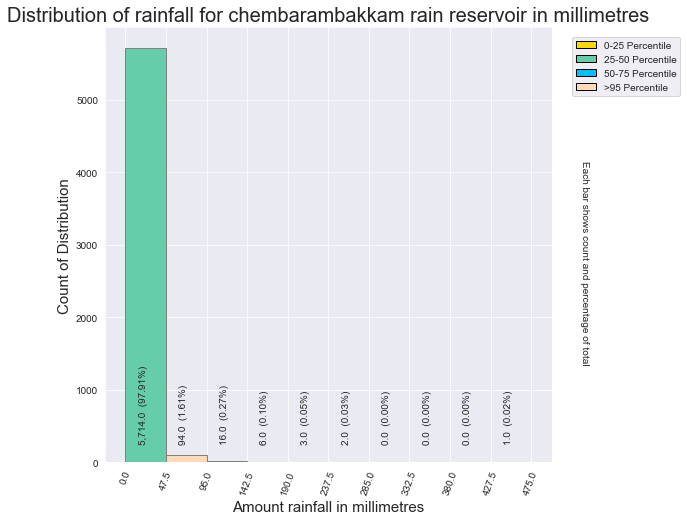

In [11]:
graph_percentile(df["chembarambakkam_rain"])


As can be seen, most of the values are zero values followed by smaller and smaller amounts of progressively higher values, with a handful of values being over 142 millimeters.

This begs the question of how these values are distributed across the years.

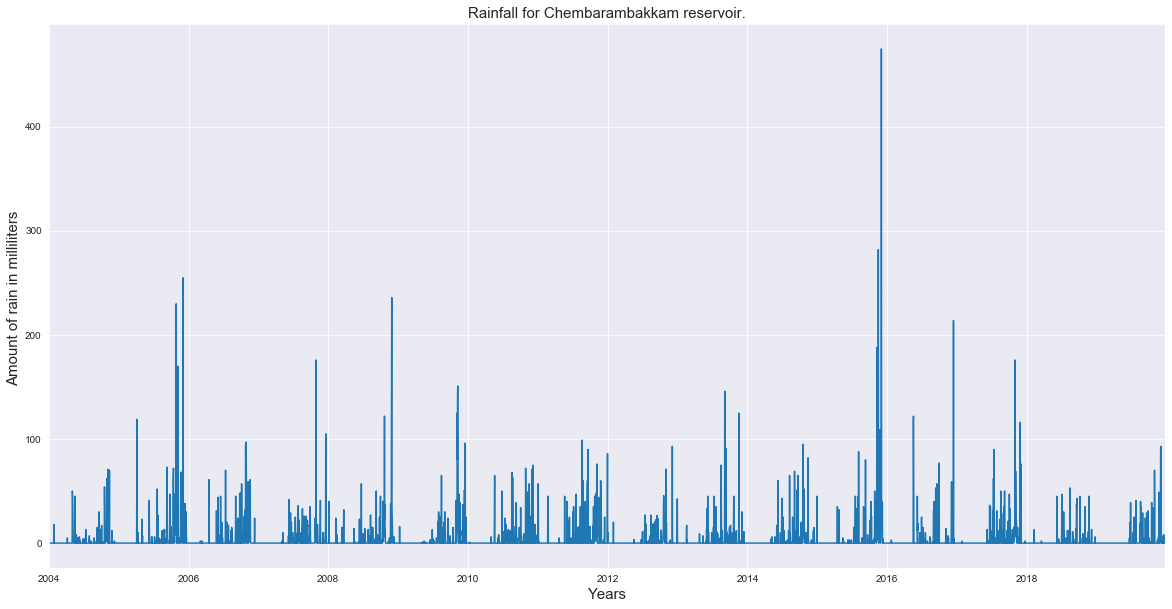

In [12]:
plot_line(df,"chembarambakkam_rain", "Years", "Amount of rain in milliliters ", "Rainfall for Chembarambakkam reservoir.")

Over here we can see that the rainfall is represented by sharp peaks and flat lines. A good portion of the year has little to no rain followed by a large amount of rain over a repeated specific amount of time.

This trend is made clearer when we look at an individual years.

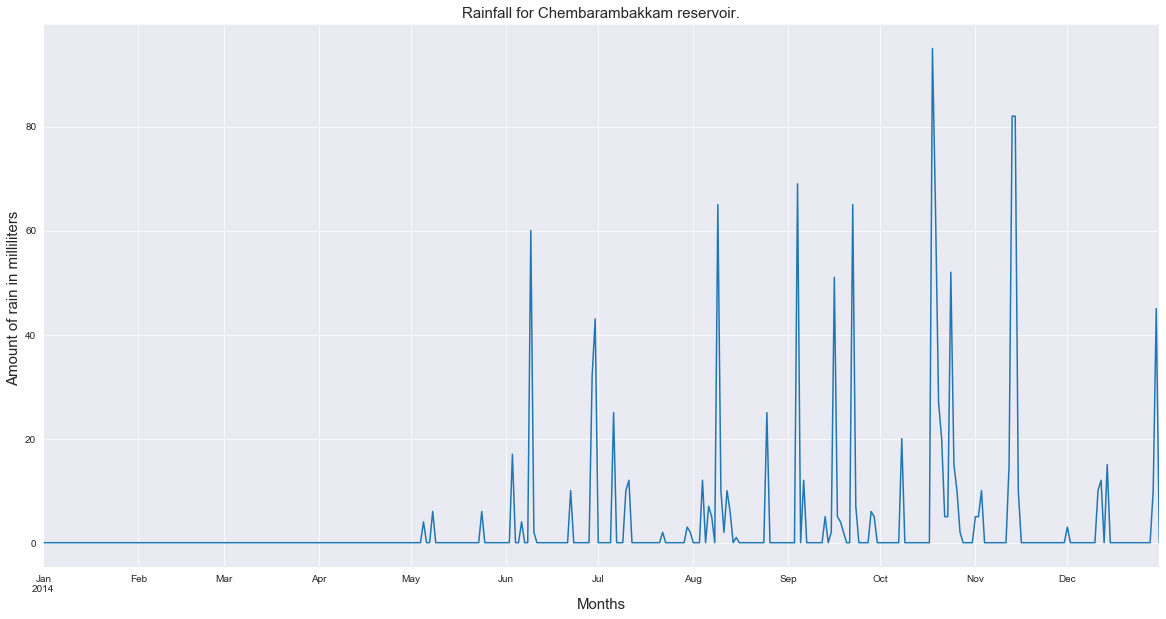

In [13]:
plot_line(df.loc['2014'],"chembarambakkam_rain", "Months", "Amount of rain in milliliters ", "Rainfall for Chembarambakkam reservoir.")

Looking at the daily rains for 2014, we see that it rains in the month of June, July, August and September. This is due to south west monsoon.            
Major rainfall also happens during October and November of every year which is due to North-east monsoon. 

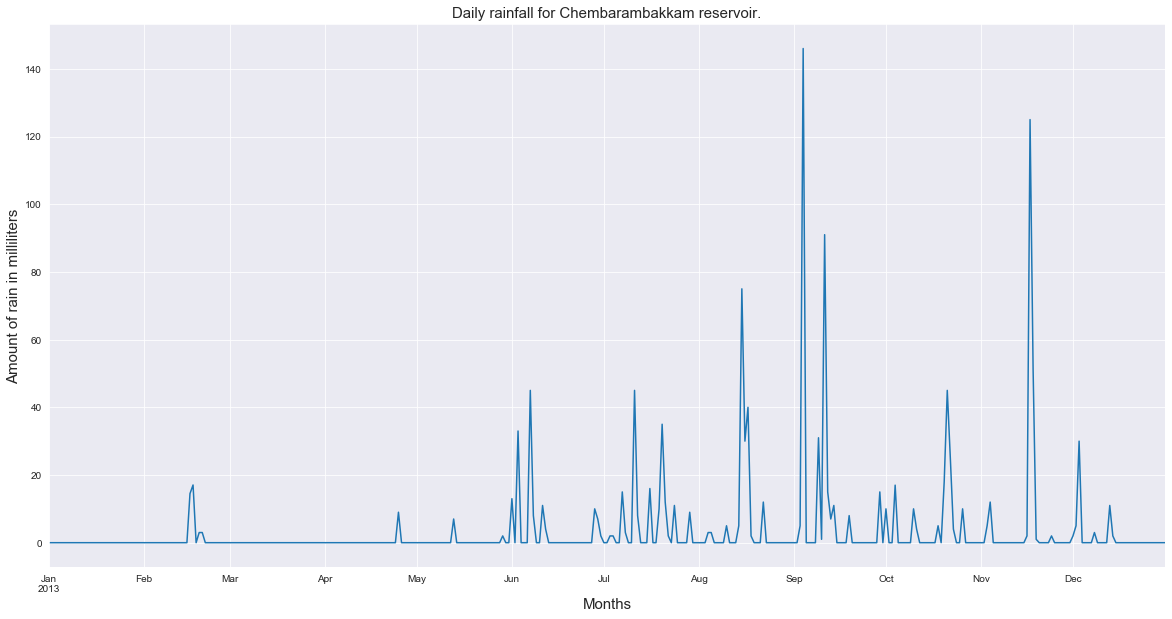

In [14]:
plot_line(df.loc['2013'],"chembarambakkam_rain", "Months", "Amount of rain in milliliters", "Daily rainfall for Chembarambakkam reservoir.")

Looking at the daily rains for 2013, we see similar findings.

All these findings make sense as India only gets on average rainfall for 54 days out of the year. The time that it does get rain it comes in the form of 2 monsoons.

This isn't to say that every year is the same. Looking at the first graph one can see that there is a massive spike in 2015. This corresponds to the massive floods that occurred throughout November and December in Chennai.

---

Moving on, we will now look at the target feature in our data the water level of the reservoir.


The appears to a lot of zero values but not nearly as many as with the rainfall values. Also, the most frequent values are low values between 0 and 500. The distribution isn't normal with a skew to the right. The average is about 1300 and a max and min of 3000 and 0 respectively.

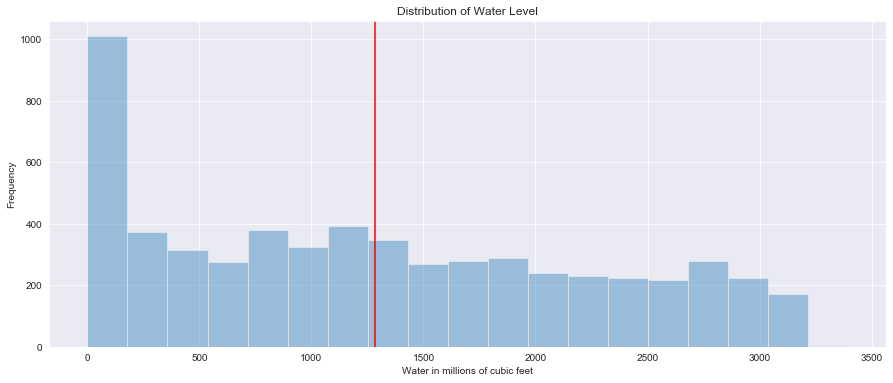

In [15]:
hist_plot(df, "chembarambakkam_water", "Water in millions of cubic feet","Frequency","Distribution of Water Level")


For our problem statement, we are trying to predict the average monthly water level in each reservoir so we are going to resample  our data to the average monthly total.

In [25]:
df_m = df.resample("m").mean()

In [28]:
df.describe()

,chembarambakkam_water,chembarambakkam_rain
count,5836.000000,5836.000000
mean,1285.674289,4.012688
std,964.355749,16.251079
min,0.000000,0.000000
25%,408.000000,0.000000
50%,1190.000000,0.000000
75%,2047.000000,0.000000
max,3396.000000,475.000000


In [29]:
df_m.describe()

,chembarambakkam_water,chembarambakkam_rain
count,192.000000,192.000000
mean,1286.661970,4.010360
std,953.320423,5.379458
min,0.000000,0.000000
25%,409.324462,0.056452
50%,1216.403226,2.148925
75%,2016.074405,5.705484
max,3161.903226,36.600000


We now have a data frame consisting of an average for rain and water level for 192 months.

Most notably the percentiles in the rain column are now not zero.

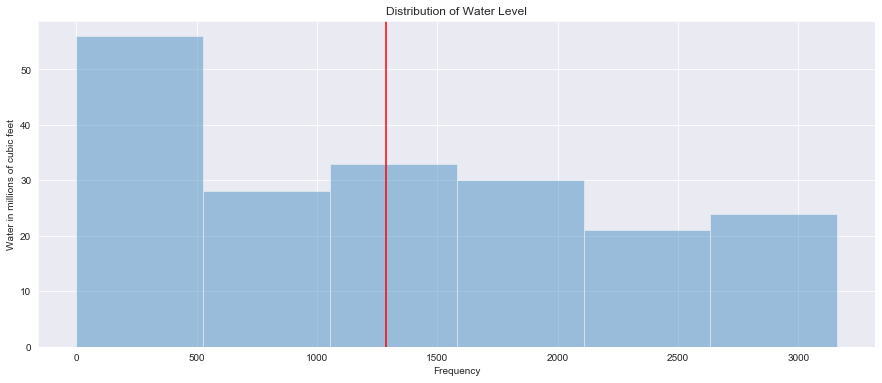

In [30]:
hist_plot(df_m, "chembarambakkam_water", "Frequency", "Water in millions of cubic feet","Distribution of Water Level")

The graph looks similar as before which makes sense as this is showing an average sum and fairly consistent with our non-resampled data.

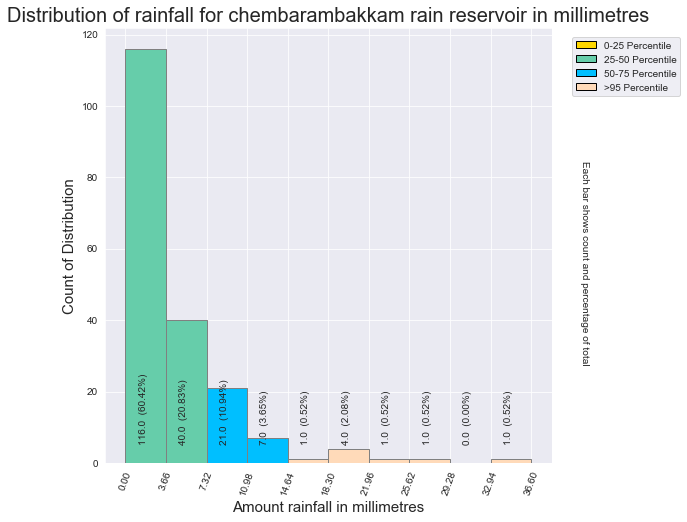

In [31]:
graph_percentile(df_m["chembarambakkam_rain"])

However, by the graph for the rain, there is a great change as now we are looking at the monthly average and not daily, so the days where there was a massive outpour is more spread out.  

---

Now we are going to look at the monthly data.

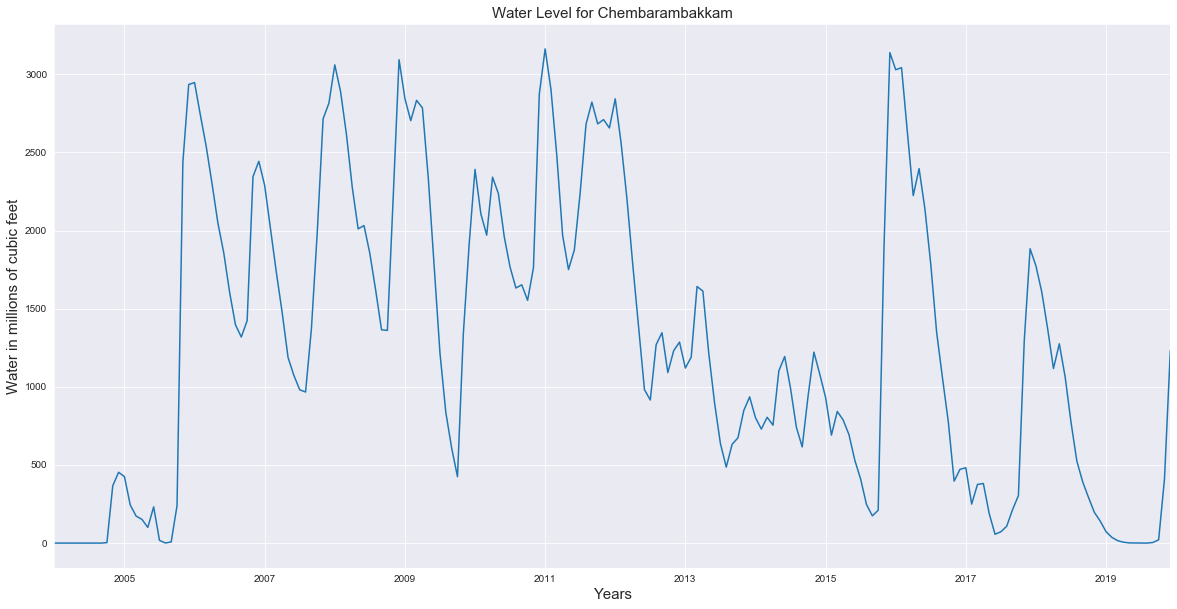

In [32]:
plot_line(df_m,"chembarambakkam_water", "Years", 
          "Water in millions of cubic feet",
          "Water Level for Chembarambakkam" )

Looking at the graph we can see several spikes above and below the average of 1300 cubic million feet.

Notable outliers include the times where the water level was zero or near zero in 2004, 2005, and most recently in 2019.

---

We are now going to look at the year of the water crisis, 2019.

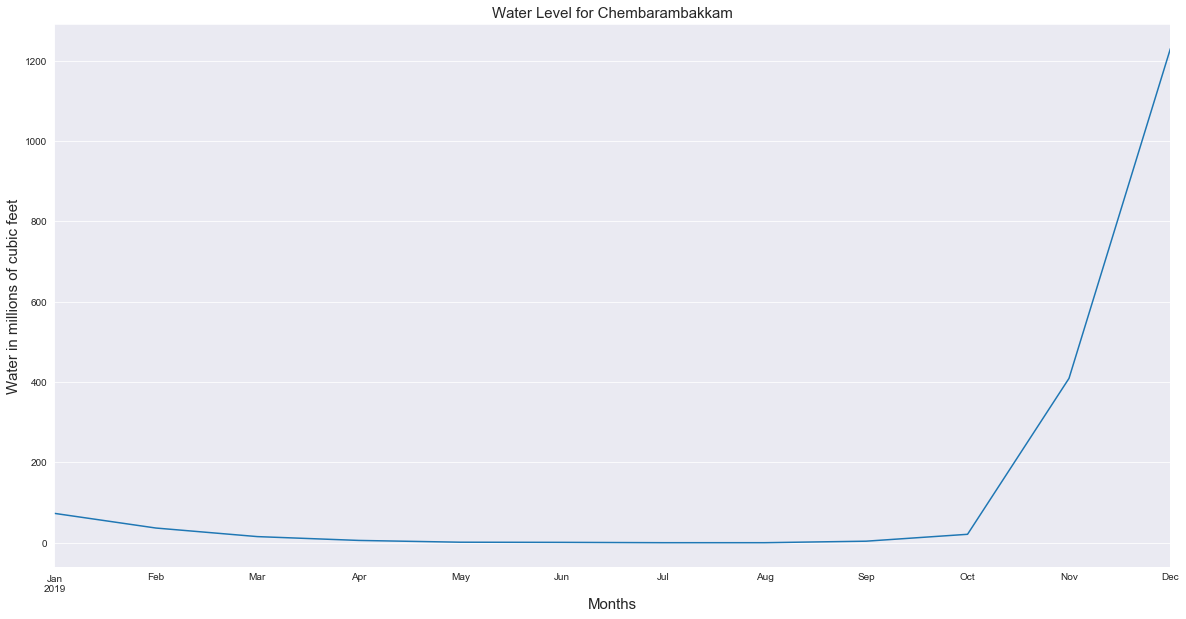

In [33]:
plot_line(df_m.loc["2019"],"chembarambakkam_water", "Months", 
          "Water in millions of cubic feet",
          "Water Level for Chembarambakkam") 

We can see that the water level was very low with the year starting at below 100 and flatting out to around 0 towards the end of April. The water level than rose toward the end of the year.

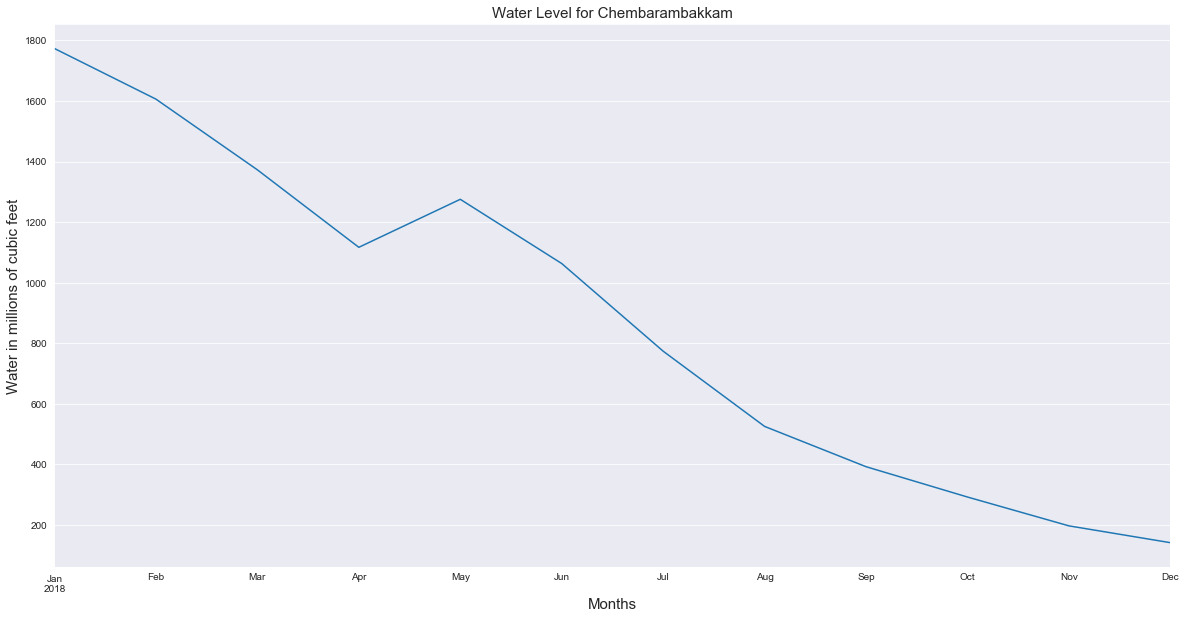

In [34]:
plot_line(df_m.loc["2018"],"chembarambakkam_water", "Months", 
          "Water in millions of cubic feet",
          "Water Level for Chembarambakkam") 

The previous year of 2018 started lower than dropped until May and than after a brief gain plummeted exponentially for the rest of the year.

If we look at the rainfall we can see that it corresponds with the rise and fall of the water level.

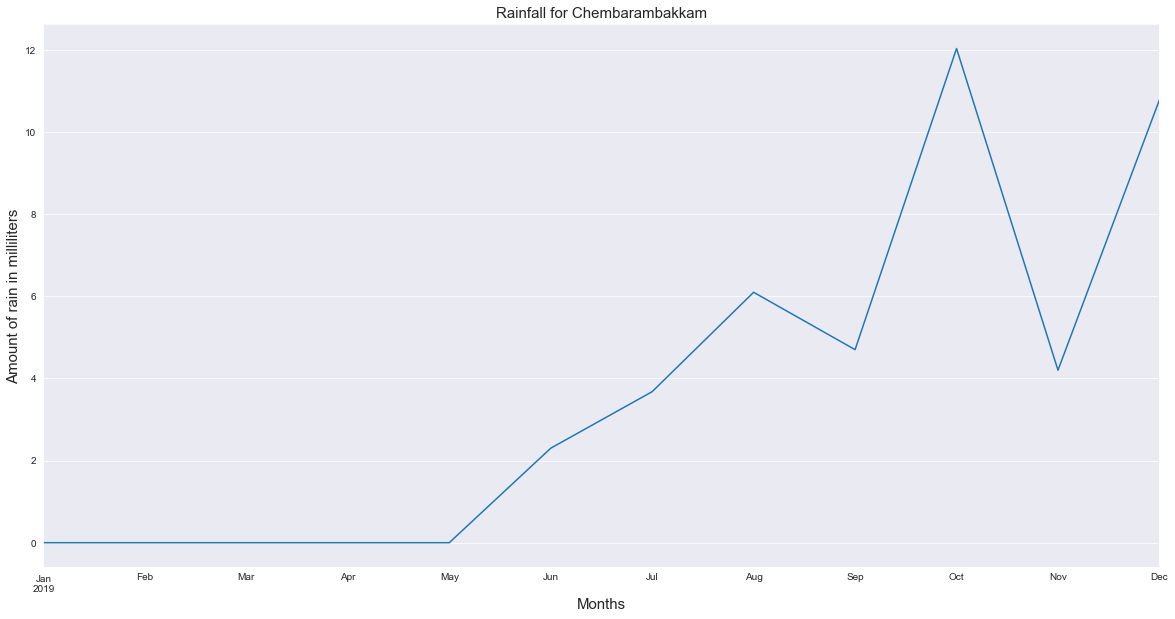

In [35]:
plot_line(df_m.loc["2019"],"chembarambakkam_rain", "Months", 
          "Amount of rain in milliliters",
          "Rainfall for Chembarambakkam") 

The rainfall is flatlined at zero and only really rises after May. The hard rainfall in October contributed to the water level rising later that year.

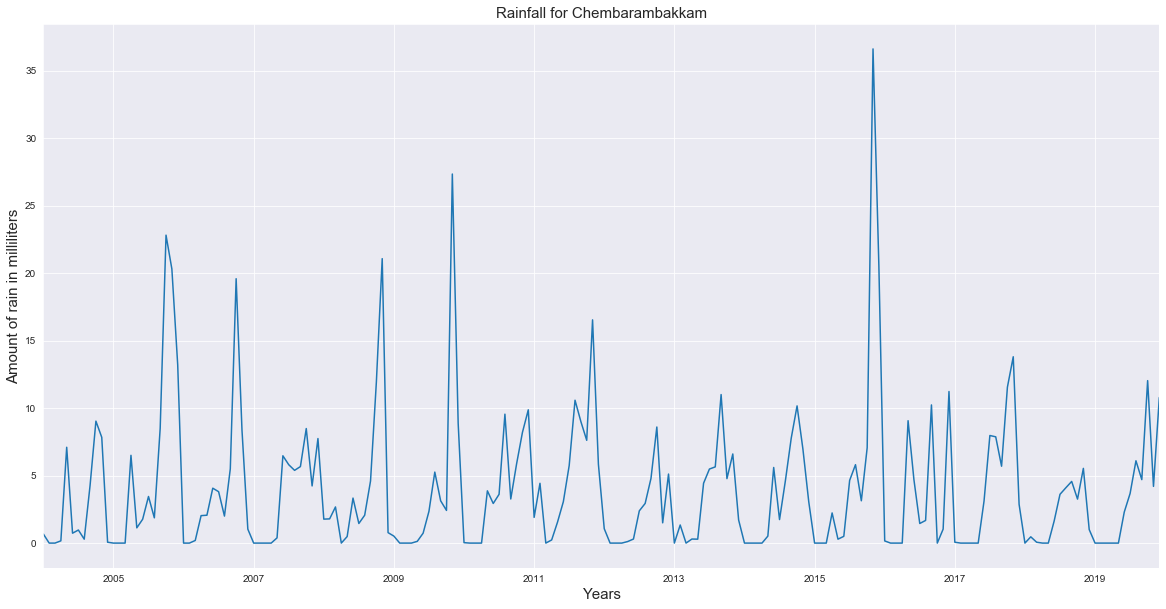

In [36]:
plot_line(df_m,"chembarambakkam_rain", "Years", 
          "Amount of rain in milliliters",
          "Rainfall for Chembarambakkam") 

---

Of the biggest factors that have caused water scarcity in Chennai, in addition to poor rains and water management, is the development of the city and population growth that has occurred in recent decades.

<img src="../assets/ch.gif" width="500px">
<img src="../assets/CHennaiGIF.gif" width="500px">


After going through the data we can see the following:

* The city gets some rains in the month of June, July, August and September due to south west monsoon.  

* Major rainfall happens during October and November of every year which is due to North-east monsoon.  
* During the initial years rain from north-east monsoon is much higher than south-west monsoon. But seems like in the last few years, they both are similar.


---

For our model evaluation, we are going to choose the linear regression model with Exogenous Variable as it scored the best $R2$.

## Model Evaluation 


I will evaluate the Linear Regression with Exogenous Variable Model by calculating the Root Mean Squared Error and by examining the residuals and looking at the Coefficients.

In [53]:
resids_train = y_train_r - y_train_preds_r 

In [54]:
resids_test = y_test_r - y_test_preds_r

In [55]:
y_test_preds_r.value_counts().sum()

50

In [56]:
rmse = np.sqrt(mean_squared_error(y_test_r, y_test_preds_r))
print(f'The RMSE is {round(rmse,2)}.')

The RMSE is 249.04.


According to the value of the RMSE, the predictions for the Average Monthly Water level by the Linear Regression Model with Exogenous Variable are likely off by about 245 million cubic feet. I would like to improve the model's predictability and try to get this number to be smaller.


### Distribution of Residuals

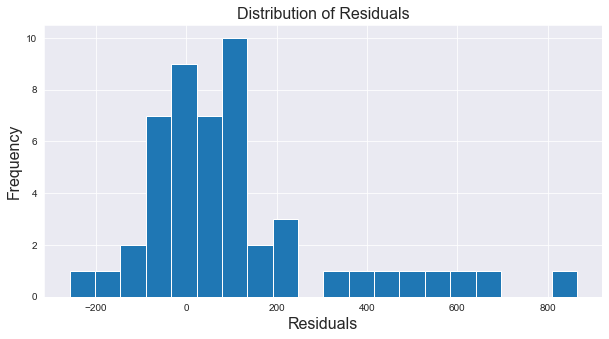

In [57]:
plt.figure(figsize=(10,5)) #determining size
plt.title('Distribution of Residuals',fontsize= 16)
plt.xlabel('Residuals',fontsize= 16)
plt.ylabel('Frequency',fontsize= 16)
plt.hist(resids_test, bins = 20);


**Interpretation**: From the above histogram, it is evident that the residuals are not normally distributed. On both tails of the distribution, there are some residuals that indicate that the model's prediction was incorrect by quite a bit. However this does not mean that our model is a bad model.

### Average Monthly Water Level Predictions compared to the actual values


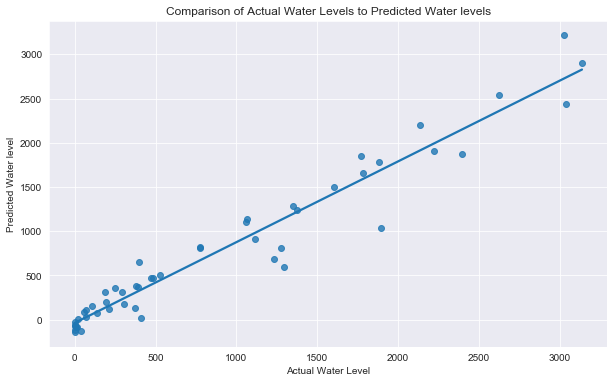

In [58]:
plt.figure(figsize=(10,6))
x = sns.regplot(x= y_test_r, y= y_test_preds_r, ci=None)
x.set(xlabel="Actual Water Level",
      ylabel= "Predicted Water level", 
      title="Comparison of Actual Water Levels to Predicted Water levels");

**Interpretation**: 
From this plot, we are able to see that this model does not perform equally well at predicting all average monthly water levels. We see that there sevaral data points clumped around zero.  

In addition, we can see that are several outliers in our testing data where the actual water level was higher than the predicted water level by about five hundred million cubic feet.

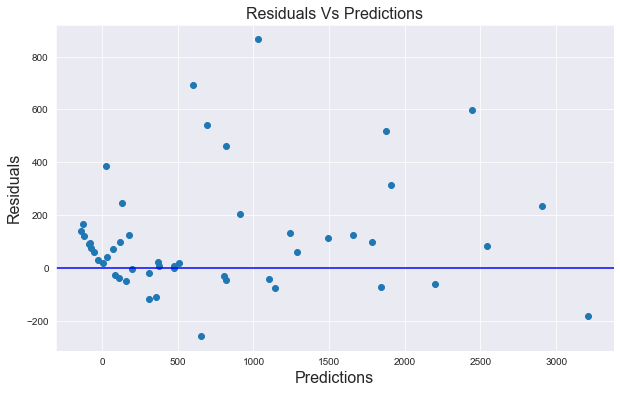

In [59]:
plt.figure(figsize=(10,6)) # determining size
plt.title("Residuals Vs Predictions",fontsize= 16) # plotting title
plt.scatter(y_test_preds_r  , resids_test);
plt.xlabel('Predictions', fontsize= 16) # plotting label
plt.ylabel('Residuals',fontsize= 16) # plotting label
plt.axhline(0, color='Blue');

**Interpretation**: We can see that the variance is fairly uniform. The residuals increase at the more extreme predicted values. The exception is by the zero where there is a v shape by the zero value.

### Looking at the coefficients

---

In [60]:
rain_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     chembarambakkam_water   R-squared:                       0.924
Model:                               OLS   Adj. R-squared:                  0.917
Method:                    Least Squares   F-statistic:                     144.1
Date:                   Wed, 23 Sep 2020   Prob (F-statistic):           1.32e-55
Time:                           14:27:45   Log-Likelihood:                -794.10
No. Observations:                    117   AIC:                             1608.
Df Residuals:                        107   BIC:                             1636.
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      160.3515    111.498      1.438      0.153     -60.680     381.383
chembarambakkam_rain         0.7699      0.183      4.201      0.000       0.407       1.133
chembarambakkam_water_1      1.3252      0.072     18.448      0.000       1.183       1.468
chembarambakkam_water_2     -0.4843      0.069     -7.002      0.000      -0.621      -0.347
chembarambakkam_water_10     0.0418      0.037      1.121      0.265      -0.032       0.116
chembarambakkam_water_13    -0.0025      0.038     -0.066      0.948      -0.077       0.072
chembarambakkam_water_23    -0.1334      0.069     -1.931      0.056      -0.270       0.004
chembarambakkam_water_24     0.2854      0.105      2.711      0.008       0.077       0.494
chembarambakkam_water_25    -0.1141      0.071     -1.616      0.109      -0.254       0.026
time                        -2.0901      0.906     -2.308      0.023      -3.886      -0.295
==============================================================================
Omnibus:                       13.196   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.073
Skew:                           0.774   Prob(JB):                     0.000879
Kurtosis:                       3.701   Cond. No.                     2.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the lags we see that given a p value of less than .05 being significant lag 1, 2, and 24 are significant.

The way that we would interpret the lags would be as follows:  
* With all held constant a 1 million cubic feet increase for one month prior, would predict a 1.32 cubic million increase for the target month.
* With all held constant a 1 million cubic feet increase for two months prior, would predict a 0.48 cubic million decrease for the target month.
* With all held constant a 1 million cubic feet increase for 24 months prior, would predict a 0.28 cubic million increase for the target month.


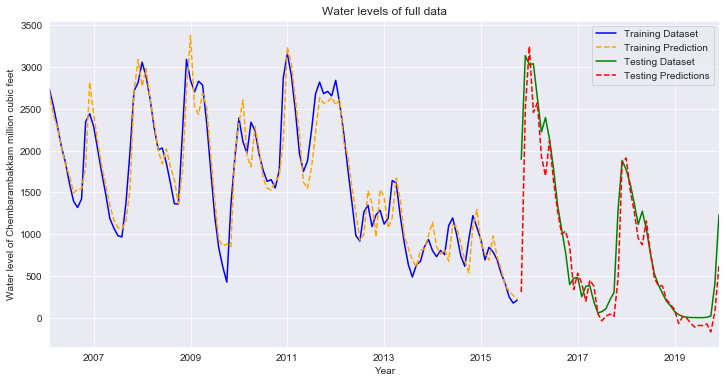

In [61]:
plt.figure(figsize=(12,6)) #d

plt.title("Water levels of full data")

y_train.plot(style="b")
y_train_preds.plot(style="orange", linestyle = "--") # orange with dash
y_test.plot(style="g")
y_test_preds.plot(style="r--") # red with dash
plt.xlabel("Year")
plt.ylabel("Water level of Chembarambakkam million cubic feet")
plt.legend(labels = ["Training Dataset", "Training Prediction", "Testing Dataset", "Testing Predictions"]);

For final thoughts and conclusions refer back to main notebook.